In [1]:
!pip3 install h5py

In [78]:
import h5py
import numpy as np

def openFile(filename):
    with h5py.File(filename, 'r') as f:
        print("Keys: %s" % f.keys())
        a_group_key = list(f.keys())[0]
        data = list(f[a_group_key])
        axis0_data = list(f[a_group_key]['axis0'])
        axis1_data = list(f[a_group_key]['axis1'])
        block0_items = list(f[a_group_key]['block0_items'])
        block0_values = list(f[a_group_key]['block0_values'])
        separate_arrays = [np.array(array) for array in block0_values]
        
        return {
            'data': data,
            'axis0_data': axis0_data,
            'axis1_data': axis1_data,
            'block0_items': block0_items,
            'block0_values': np.array(separate_arrays),
        }
    
    
data1 = openFile('Data/uni_111.h5')
data2 = openFile('Data/uni_112.h5')
data3 = openFile('Data/uni_113.h5')

Keys: <KeysViewHDF5 ['EEG']>
Keys: <KeysViewHDF5 ['EEG']>
Keys: <KeysViewHDF5 ['EEG']>


In [87]:
print(data1['block0_values'])

[[ 5.21388197e+01  7.60388050e+01  6.90253868e+01 ...  5.96603377e+01
   5.82450226e+01  4.05887058e+01]
 [ 6.90003894e+01  7.95133720e+01  1.14963601e+02 ...  7.80196819e+01
   7.89633340e+01  6.15745931e+01]
 [ 7.18162072e+01  7.60578973e+01  1.30431279e+02 ...  8.52816545e+01
   8.40137605e+01  6.54350226e+01]
 ...
 [-5.09690961e-01 -1.68317817e+00 -3.55121633e+00 ...  7.43748608e-01
   3.57305319e-01 -2.66479713e-02]
 [ 8.71479035e-02 -1.10954660e+00 -2.90077585e+00 ...  1.03520362e+00
   8.08741713e-01  5.64112848e-01]
 [ 7.40186015e-02 -1.12274753e+00 -2.75612269e+00 ...  8.62963036e-01
   6.36846890e-01  3.24022190e-01]]


In [79]:
def dataAnalysis(data):
    print("There are %d electrode planes from which data is collected" % len(data['axis0_data']))
    print("There are %d signals collected from each electrode plane" % len(data['axis1_data']))
    print("With frequency of 200 signals in a second, the data is collected in %.2f minutes or %d seconds" % (len(data['axis1_data'])/60/200, len(data['axis1_data'])/200))
    print("-----------------------------------------------------")

dataAnalysis(data1)
dataAnalysis(data2)
dataAnalysis(data3)
       

There are 44 electrode planes from which data is collected
There are 94800 signals collected from each electrode plane
With frequency of 200 signals in a second, the data is collected in 7.90 minutes or 474 seconds
-----------------------------------------------------
There are 44 electrode planes from which data is collected
There are 101200 signals collected from each electrode plane
With frequency of 200 signals in a second, the data is collected in 8.43 minutes or 506 seconds
-----------------------------------------------------
There are 44 electrode planes from which data is collected
There are 109600 signals collected from each electrode plane
With frequency of 200 signals in a second, the data is collected in 9.13 minutes or 548 seconds
-----------------------------------------------------


### Correlation between channnels 44x44

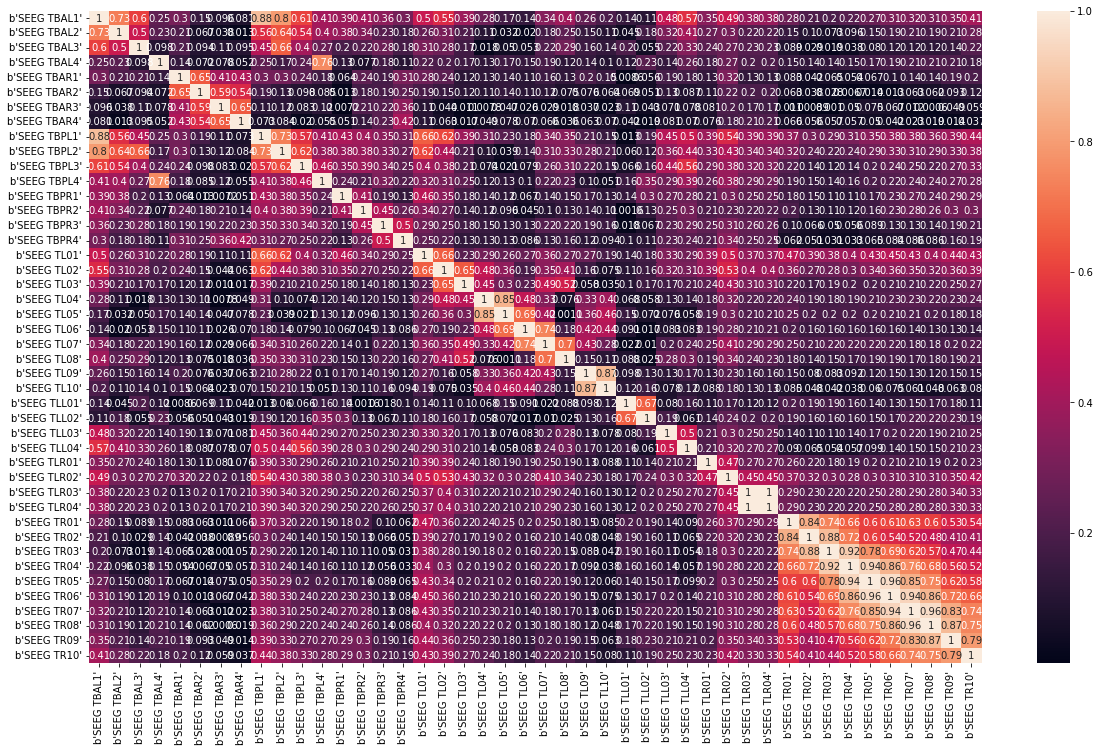

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

def createCorrelationMatrix(data, start, end):
    block_data = data['block0_values']
    reshaped_data = block_data.reshape(-1, block_data.shape[1])
    correlation_matrix = np.corrcoef(block_data[start:end].T)
    correlation_matrix = np.abs(correlation_matrix)
    # make it a binary matrix
    correlation_matrix[correlation_matrix < 0.5] = 0
    correlation_matrix[correlation_matrix >= 0.5] = 1
    # make the diagonal 0
    np.fill_diagonal(correlation_matrix, 0)
    # make lower triangle 0
    correlation_matrix = np.tril(correlation_matrix, k=-1)
    channel_names = data['block0_items']
    plt.figure(figsize=(20, 12))
    sns.heatmap(correlation_matrix, annot=True, xticklabels=channel_names, yticklabels=channel_names)
    plt.show()


# def subPlotForCorrelationMatrix(data):
#     window_size = 5000
#     fig, axs = plt.subplots(1, len(data['block0_values'])//window_size, figsize=(20, 20))
#     for i in range(0, len(data['block0_values']), window_size):
#         correlation_matrix = np.corrcoef(data['block0_values'][i:i+window_size].T)
#         correlation_matrix = np.abs(correlation_matrix)
#         channel_names = data['block0_items']
#         sns.heatmap(correlation_matrix, ax=axs[i//window_size], annot=True, xticklabels=channel_names, yticklabels=channel_names)
#     plt.show()
      
    
# subPlotForCorrelationMatrix(data1)
createCorrelationMatrix(data1, 0, 5000)
# print((data1['block0_values'].shape))

/home/abhishek/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


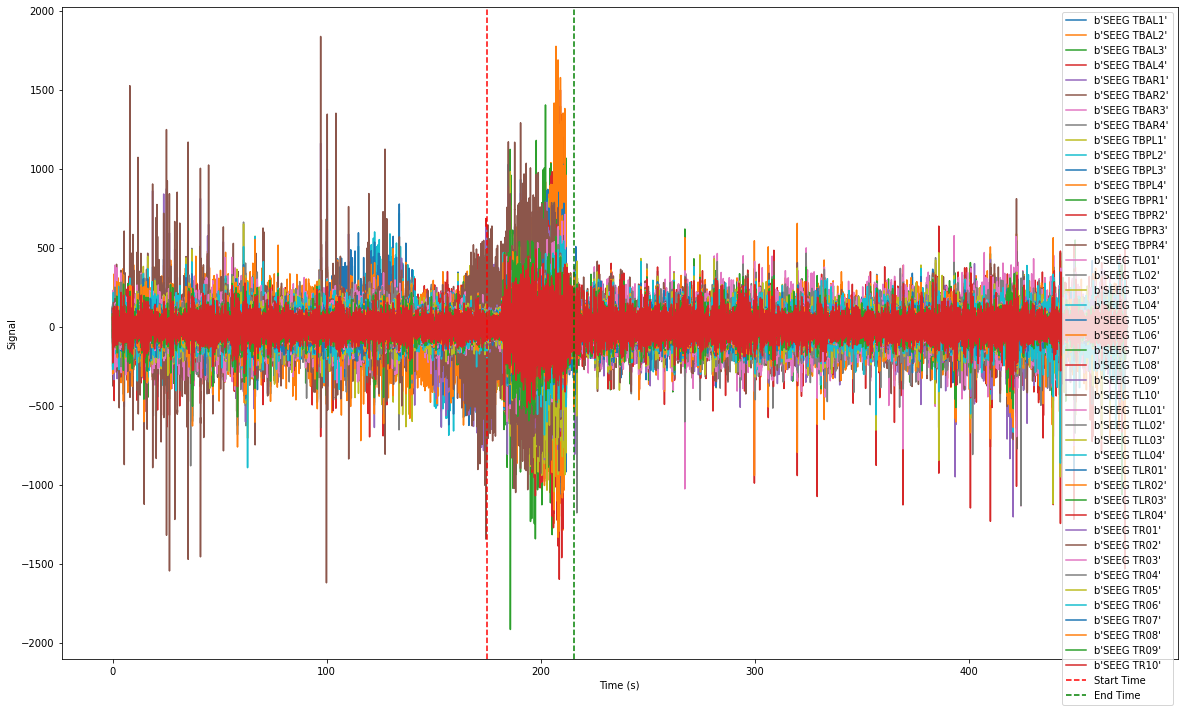

In [98]:
def create_time_series_plot(data, vertical_lines):
    start_time, end_time = vertical_lines
    block_data = data['block0_values']
    # calculate the time axis 
    time_axis = np.arange(0, len(data['axis1_data'])/200, 1/200)
    # plot the time series
    plt.figure(figsize=(20, 12))
    for i in range(block_data.shape[1]):
        plt.plot(time_axis, block_data[:, i], label=data['block0_items'][i])
    # plot the vertical lines
    plt.axvline(x=start_time, color='r', linestyle='--', label='Start Time')
    plt.axvline(x=end_time, color='g', linestyle='--', label='End Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.legend()
    plt.show()

create_time_series_plot(data1, [174.87, 215.505])


/home/abhishek/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


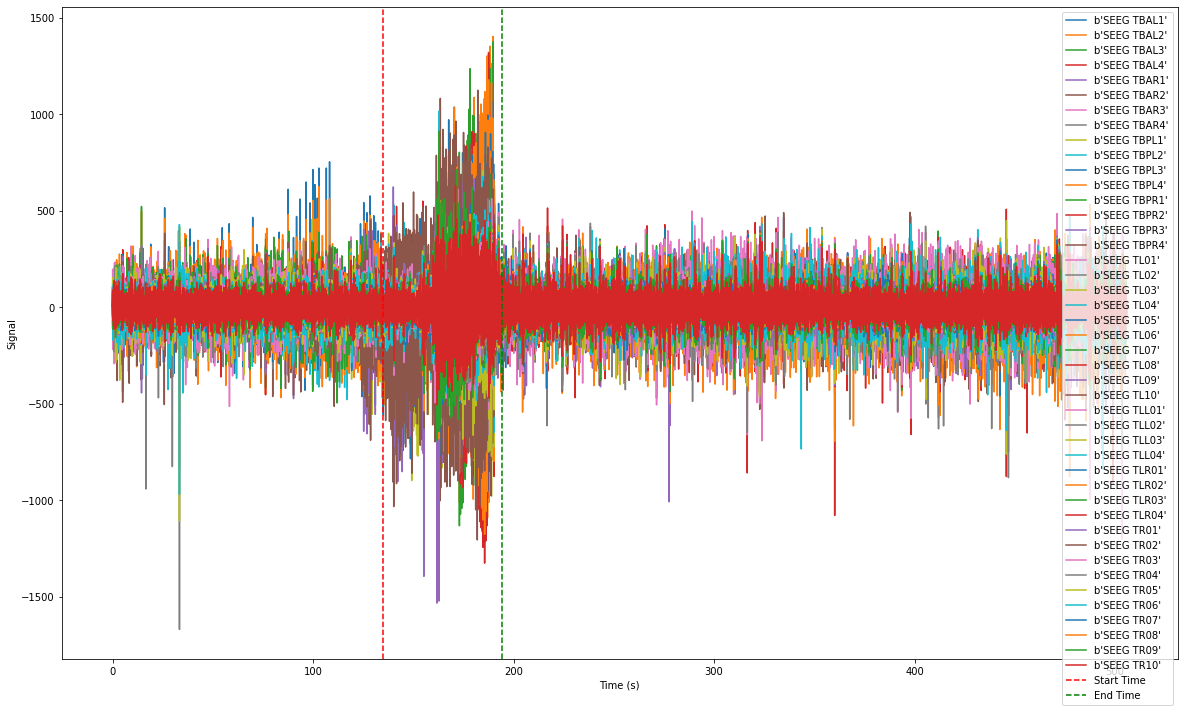

/home/abhishek/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


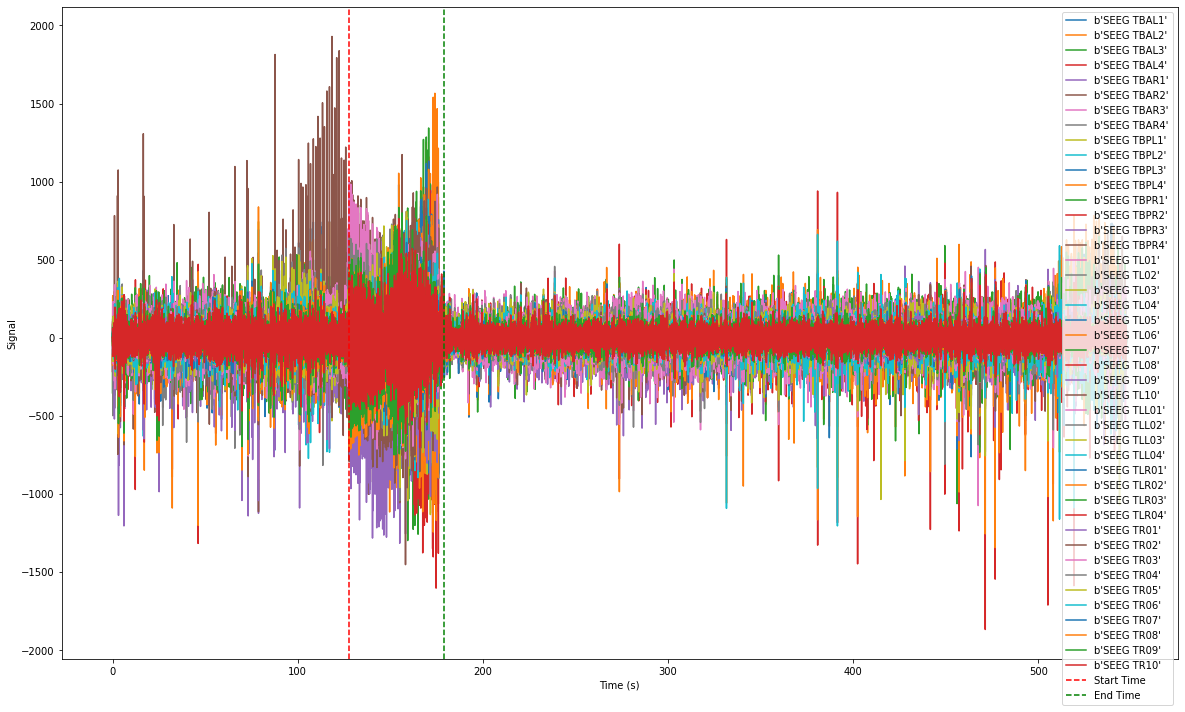

In [99]:
create_time_series_plot(data2, [134.995, 194.14])
create_time_series_plot(data3, [127.81, 179.1])